In [3]:
import numpy as np
import networkx as nx
import scipy.sparse as sp
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import global_add_pool

import networkx as nx
from random import shuffle
from scipy.io import loadmat

AE: encoder, decoder <br>
Encoder: GNN (map graph to vector)<br>
Decoder: MLP (reconstruct adjacency matrix)<br>

VAE: embed input into distribution (here Gaussian, and we compute the mean)

# Utils

In [4]:
def normalize_adjacency(A):
    # Normalizes adjacency matrix represnted as a sparse SciPy matrix
    n = A.shape[0]
    A += sp.identity(n)
    degs = A.dot(np.ones(n))
    inv_degs = np.power(degs, -1)
    D_inv = sp.diags(inv_degs)
    A_normalized = D_inv.dot(A)
    return A_normalized

def sparse_mx_to_torch_sparse(M):
    # Converts a sparse SciPy matrix to a sparse PyTorch tensor
    M = M.tocoo().astype(np.float32)
    indices = torch.from_numpy(np.vstack((M.row, M.col)).astype(np.int64))
    values = torch.from_numpy(M.data)
    shape = torch.Size(M.shape)
    return torch.sparse.FloatTensor(indices, values, shape)

def find_communities_and_plot(G):
    # Compute the best partition using Louvain algorithm
    partition = nx.community.louvain_communities(G)
    
    # Reorder the adjacency matrix
    ordered_nodes = list()
    for p in partition:
        for node in p:
            ordered_nodes.append(node)
    
    reordered_matrix = nx.to_numpy_array(G, nodelist=ordered_nodes)
    
    # Plot adjacency matrix
    plt.imshow(reordered_matrix, cmap='gray')
    plt.title("Reordered Adjacency Matrix")
    plt.show()

    # Draw the graph
    plt.title('Generated graph')
    nx.draw(G)
    plt.show()

# Model

In [5]:
# Decoder
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, n_layers, n_nodes, dropout=0.2):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.n_nodes = n_nodes

        self.fc = nn.ModuleList()
        self.fc.append(nn.Sequential(nn.Linear(latent_dim, hidden_dim),  
                            nn.ReLU(),
                            nn.LayerNorm(hidden_dim), 
                            nn.Dropout(dropout)
                            ))

        for i in range(1, n_layers):
            self.fc.append(nn.Sequential(nn.Linear(hidden_dim*i, hidden_dim*(i+1)),  
                            nn.ReLU(),
                            nn.LayerNorm(hidden_dim*(i+1)), 
                            nn.Dropout(dropout)
                            ))
        
        self.fc_proj = nn.Linear(hidden_dim*n_layers, n_nodes*n_nodes)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        ############## Task 10
    
        ##################
        # your code here #
        ##################

        for i in range(self.n_layers):
            x = self.fc[i](x)
        
        x = self.fc_proj(x)
        x = x.reshape(-1, self.n_nodes, self.n_nodes)
        adj = 0.5 * (x + torch.transpose(x, 1, 2))
        
        return adj

# Encoder
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, n_layers, dropout=0.2):
        super(Encoder, self).__init__()
        self.n_layers = n_layers        
        self.mlps = torch.nn.ModuleList()
        self.mlps.append(nn.Sequential(nn.Linear(input_dim, hidden_dim),  
                            nn.ReLU(),
                            nn.Linear(hidden_dim, hidden_dim), 
                            nn.ReLU()
                            ))

        for layer in range(n_layers-1):
            self.mlps.append(nn.Sequential(nn.Linear(hidden_dim, hidden_dim),  
                            nn.ReLU(),
                            nn.Linear(hidden_dim, hidden_dim), 
                            nn.ReLU()
                            ))

        self.fc = nn.Linear(hidden_dim, hidden_dim)
        self.relu = nn.ReLU()

    def forward(self, adj, x, idx):
        ############## Task 8
    
        ##################
        # your code here #
        ##################

        for i in range(self.n_layers):
            x = torch.mm(adj, x)
            x = self.mlps[i](x)


        # Readout
        idx = idx.unsqueeze(1).repeat(1, x.size(1))
        out = torch.zeros(torch.max(idx)+1, x.size(1), device=x.device, requires_grad=False)
        out = out.scatter_add_(0, idx, x)
        
        out = self.fc(out)
        return out


# Variational Autoencoder
class VariationalAutoEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim_enc, hidden_dim_dec, latent_dim, n_layers_enc, n_layers_dec, n_max_nodes):
        super(VariationalAutoEncoder, self).__init__()
        self.n_max_nodes = n_max_nodes
        self.input_dim = input_dim
        self.encoder = Encoder(input_dim, hidden_dim_enc, hidden_dim_enc, n_layers_enc)
        self.fc_mu = nn.Linear(hidden_dim_enc, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim_enc, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim_dec, n_layers_dec, n_max_nodes) 

    def reparameterize(self, mu, logvar, eps_scale=1.):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = torch.randn_like(std) * eps_scale
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, mu):
        adj = self.decoder(mu)
        adj = torch.sigmoid(adj)
        adj = adj * (1 - torch.eye(adj.size(-2), adj.size(-1), device=adj.device))
        return adj

    def loss_function(self, adj, x, idx, y, beta=0.05):
        x_g  = self.encoder(adj, x, idx)
        
        ############## Task 9
    
        mu = self.fc_mu(x_g) # your code here
        logvar = self.fc_logvar(x_g) # your code here
        
        x_g = self.reparameterize(mu, logvar)
        adj = self.decoder(x_g)
        
        triu_idx = torch.triu_indices(self.n_max_nodes, self.n_max_nodes)
        recon = F.binary_cross_entropy_with_logits(adj[:,triu_idx[0,:],triu_idx[1,:]], y[:,triu_idx[0,:],triu_idx[1,:]], reduction='sum', pos_weight=torch.tensor(1./0.4))
        kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        loss = recon + beta*kld

        return loss, recon, kld

# Main

In [7]:
np.random.seed(13)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
epochs = 100
batch_size = 32
hidden_dim_encoder = 32
n_layers_encoder = 2
latent_dim = 16
hidden_dim_decoder = 32
n_layers_decoder = 2
max_nodes = 40
input_feats = 2

# Load dataset

data_path = '/Users/halvardbariller/Desktop/M2 MVA/_SEMESTER 1/ALTEGRAD/TP/TP7/lab7_learning_on_sets_and_graph_generative_models/code/data/sbm.mat'
adj_dict = loadmat(data_path)
adj = [adj_dict['G'+str(i)] for i in range(1000)]
n_graphs = len(adj)

# Normalize adjacency matrices
adj_normalized = [normalize_adjacency(adj[i]) for i in range(len(adj))]

# Compute node features
x = list()
for i in range(len(adj)):
    n = adj[i].shape[0]
    v = np.zeros((n,2))
    v[:,0] = adj[i].dot(np.ones(n))/max_nodes
    v[:,1] = adj[i].dot(v[:,0])/max_nodes
    x.append(v)

# Slit into training and validation sets
idx = np.random.permutation(n_graphs)
train_idx = [int(i) for i in idx[:int(0.9*idx.size)]]
val_idx = [int(i) for i in idx[int(0.9*idx.size):]]

n_train = len(train_idx)
n_val = len(val_idx)

# Initialize autoencoder
autoencoder = VariationalAutoEncoder(input_feats, hidden_dim_encoder, hidden_dim_decoder, latent_dim, n_layers_encoder, n_layers_decoder, max_nodes).to(device)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)

# Train autoencoder
best_val_loss = np.inf
for epoch in range(1, epochs+1):
    autoencoder.train()
    train_loss_all = 0
    train_count = 0
    train_loss_all_recon = 0
    train_loss_all_kld = 0

    shuffle(train_idx)

    for i in range(0, n_train, batch_size):
        adj_batch = list()
        x_batch = list()
        idx_batch = list()
        y_batch = list()
        for j in range(i, min(n_train, i+batch_size)):
            n = adj[train_idx[j]].shape[0]
            adj_batch.append(adj_normalized[train_idx[j]])
            x_batch.append(x[train_idx[j]])
            idx_batch += [j-i]*n
            y_batch.append(np.expand_dims(np.pad(adj[train_idx[j]].todense(), ((0,max_nodes-n),(0,max_nodes-n))), axis=0))
        
        adj_batch = sp.block_diag(adj_batch)
        x_batch = np.vstack(x_batch)
        y_batch = np.vstack(y_batch)

        adj_batch = sparse_mx_to_torch_sparse(adj_batch).to(device)
        x_batch = torch.FloatTensor(x_batch).to(device)
        idx_batch = torch.LongTensor(idx_batch).to(device)
        y_batch = torch.FloatTensor(y_batch).to(device)
        
        optimizer.zero_grad()
        loss, recon, kld  = autoencoder.loss_function(adj_batch, x_batch, idx_batch, y_batch)
        train_loss_all_recon += recon.item()
        train_loss_all_kld += kld.item()
        loss.backward()
        train_loss_all += loss.item()
        train_count += torch.max(idx_batch)+1
        optimizer.step()

    autoencoder.eval()
    val_loss_all = 0
    val_count = 0
    val_loss_all_recon = 0
    val_loss_all_kld = 0

    for i in range(0, n_val, batch_size):
        adj_batch = list()
        x_batch = list()
        idx_batch = list()
        y_batch = list()
        for j in range(i, min(n_val, i+batch_size)):
            n = adj[val_idx[j]].shape[0]
            adj_batch.append(adj_normalized[val_idx[j]])
            x_batch.append(x[val_idx[j]])
            idx_batch += [j-i]*n
            y_batch.append(np.expand_dims(np.pad(adj[val_idx[j]].todense(), ((0,max_nodes-n),(0,max_nodes-n))), axis=0))
        
        adj_batch = sp.block_diag(adj_batch)
        x_batch = np.vstack(x_batch)
        y_batch = np.vstack(y_batch)

        adj_batch = sparse_mx_to_torch_sparse(adj_batch).to(device)
        x_batch = torch.FloatTensor(x_batch).to(device)
        idx_batch = torch.LongTensor(idx_batch).to(device)
        y_batch = torch.FloatTensor(y_batch).to(device)

        loss, recon, kld  = autoencoder.loss_function(adj_batch, x_batch, idx_batch, y_batch)
        val_loss_all_recon += recon.item()
        val_loss_all_kld += kld.item()
        val_loss_all += loss.item()
        val_count += torch.max(idx_batch)+1

    if epoch % 5 == 0:
        print('Epoch: {:04d}, Train Loss: {:.5f}, Train Reconstruction Loss: {:.2f}, Train KLD Loss: {:.2f}, Val Loss: {:.5f}, Val Reconstruction Loss: {:.2f}, Val KLD Loss: {:.2f}'.format(epoch, train_loss_all/train_count, train_loss_all_recon/train_count, train_loss_all_kld/train_count, val_loss_all/val_count, val_loss_all_recon/val_count, val_loss_all_kld/val_count))
        
autoencoder.eval()

/var/folders/0m/07y4vn414bng8jcy4nv9qj900000gp/T/ipykernel_36422/3727852871.py:17: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:607.)
  return torch.sparse.FloatTensor(indices, values, shape)


Epoch: 0005, Train Loss: 426.01578, Train Reconstruction Loss: 425.29, Train KLD Loss: 14.50, Val Loss: 421.36926, Val Reconstruction Loss: 420.52, Val KLD Loss: 17.00
Epoch: 0010, Train Loss: 354.12613, Train Reconstruction Loss: 352.69, Train KLD Loss: 28.78, Val Loss: 367.84668, Val Reconstruction Loss: 366.35, Val KLD Loss: 29.89
Epoch: 0015, Train Loss: 337.48309, Train Reconstruction Loss: 335.69, Train KLD Loss: 35.78, Val Loss: 344.82782, Val Reconstruction Loss: 342.94, Val KLD Loss: 37.68
Epoch: 0020, Train Loss: 318.59708, Train Reconstruction Loss: 316.46, Train KLD Loss: 42.80, Val Loss: 328.33173, Val Reconstruction Loss: 326.20, Val KLD Loss: 42.68
Epoch: 0025, Train Loss: 320.18073, Train Reconstruction Loss: 318.05, Train KLD Loss: 42.53, Val Loss: 325.22708, Val Reconstruction Loss: 323.07, Val KLD Loss: 43.05
Epoch: 0030, Train Loss: 302.99820, Train Reconstruction Loss: 300.69, Train KLD Loss: 46.17, Val Loss: 308.14316, Val Reconstruction Loss: 305.85, Val KLD Loss

VariationalAutoEncoder(
  (encoder): Encoder(
    (mlps): ModuleList(
      (0): Sequential(
        (0): Linear(in_features=2, out_features=32, bias=True)
        (1): ReLU()
        (2): Linear(in_features=32, out_features=32, bias=True)
        (3): ReLU()
      )
      (1): Sequential(
        (0): Linear(in_features=32, out_features=32, bias=True)
        (1): ReLU()
        (2): Linear(in_features=32, out_features=32, bias=True)
        (3): ReLU()
      )
    )
    (fc): Linear(in_features=32, out_features=32, bias=True)
    (relu): ReLU()
  )
  (fc_mu): Linear(in_features=32, out_features=16, bias=True)
  (fc_logvar): Linear(in_features=32, out_features=16, bias=True)
  (decoder): Decoder(
    (fc): ModuleList(
      (0): Sequential(
        (0): Linear(in_features=16, out_features=32, bias=True)
        (1): ReLU()
        (2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (3): Dropout(p=0.2, inplace=False)
      )
      (1): Sequential(
        (0): Linear(in_f

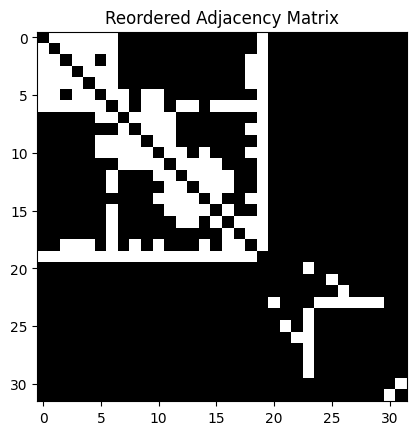

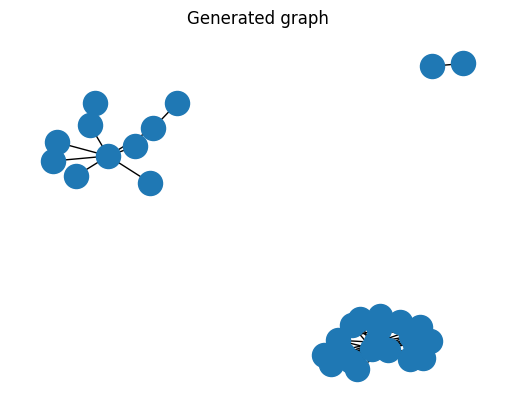

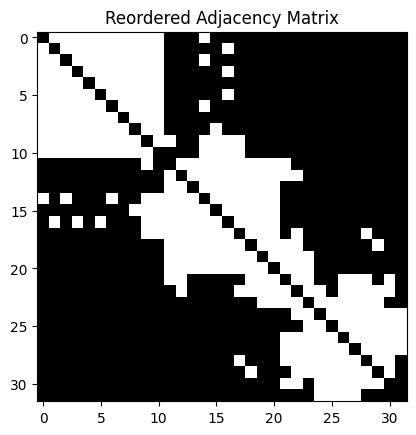

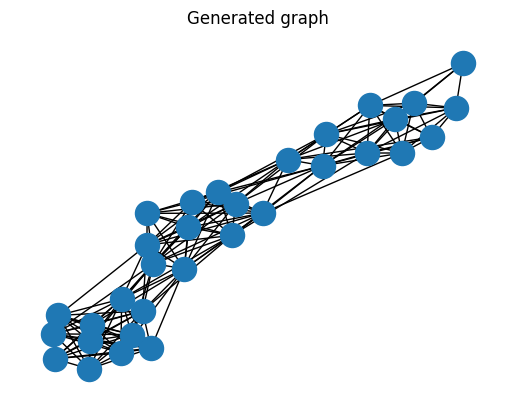

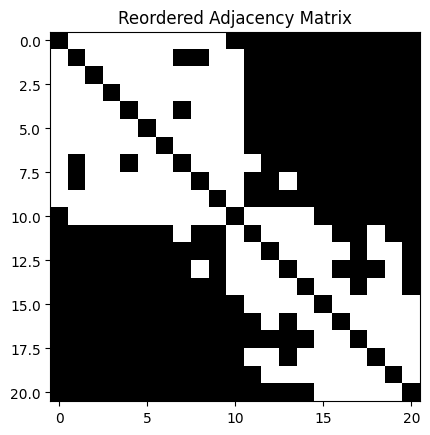

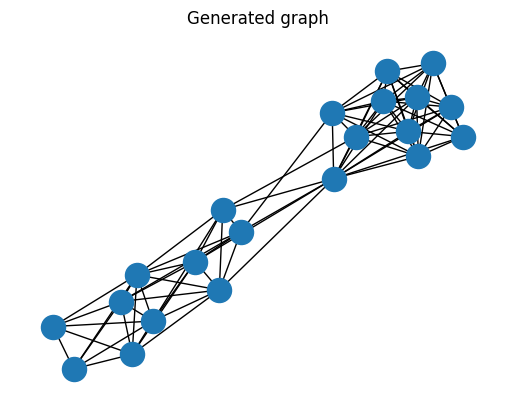

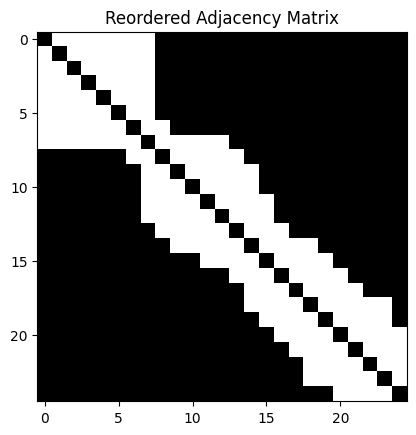

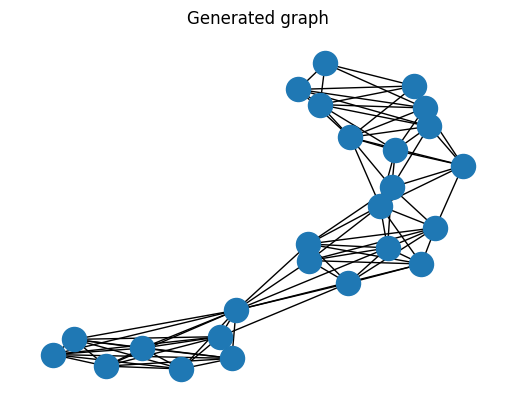

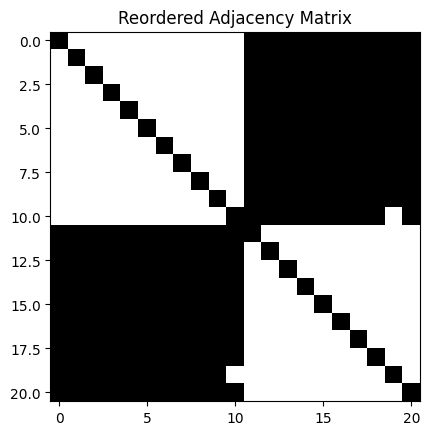

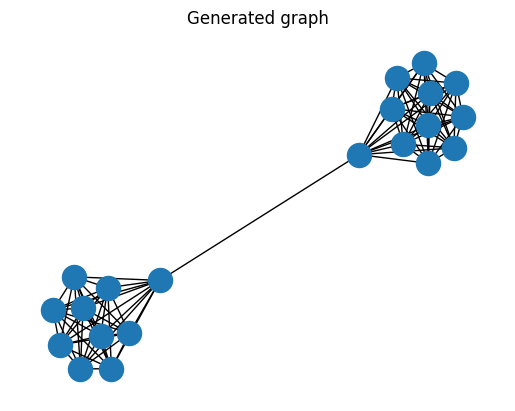

In [8]:
############## Task 11
z = torch.randn(5, latent_dim) # your code here #
adj = autoencoder.decode(z) # your code here #


# Create and visualize graphs
for i in range(adj.size(0)):
    A = adj[i,:,:].detach().cpu().numpy()
    A[A>=0.5] = 1
    A[A<0.5] = 0
    G = nx.from_numpy_array(A)
    to_remove = list()
    for node in G.nodes():
        if G.degree(node) == 0:
            to_remove.append(node)
    G.remove_nodes_from(to_remove)
    find_communities_and_plot(G)